In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

2023-04-12 13:49:00.935129: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 13:49:01.125230: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-12 13:49:01.126327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 13:49:02.154504: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
from io import BytesIO

from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib.transforms import IdentityTransform

In [6]:
attribute_path = "/home/ali/projects/photo_collection/celebface-archive/list_attr_celeba.csv"
partition_path = "/home/ali/projects/photo_collection/celebface-archive/list_eval_partition.csv"
images_path = "/home/ali/projects/photo_collection/celebface-archive/img_align_celeba/img_align_celeba/"
batch_size = 128
model_handle = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"
image_size = (224, 224)

In [7]:
df_attributes = pd.read_csv(attribute_path)

In [8]:
df_attributes.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [9]:
selected_attributes = ["5_o_Clock_Shadow", "Bald", "Bangs", "Black_Hair", "Blond_Hair", "Brown_Hair",
                       "Eyeglasses", "Goatee", "Gray_Hair", "Male", "Mustache", "No_Beard", "Sideburns", "Smiling", "Straight_Hair", "Wavy_Hair",
                       "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", "Wearing_Necktie"]

In [10]:
column_list = ["image_id"]
column_list.extend(selected_attributes)

In [11]:
df_attributes_selected = df_attributes[df_attributes.columns.intersection(column_list)].copy()

In [12]:
df_attributes_selected.head()

,image_id,5_o_Clock_Shadow,Bald,Bangs,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,...,No_Beard,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie
0,000001.jpg,-1,-1,-1,-1,-1,1,-1,-1,-1,...,1,-1,1,1,-1,1,-1,1,-1,-1
1,000002.jpg,-1,-1,-1,-1,-1,1,-1,-1,-1,...,1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,000003.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,1,-1,-1,-1,-1,-1
3,000004.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,1,-1,1,-1,1,1,-1
4,000005.jpg,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,1,-1,-1


In [13]:
df_partition = pd.read_csv(partition_path)

In [14]:
df = pd.merge(df_attributes_selected, df_partition, on="image_id")
df = df.replace(-1,0)
df.head()

,image_id,5_o_Clock_Shadow,Bald,Bangs,Black_Hair,Blond_Hair,Brown_Hair,Eyeglasses,Goatee,Gray_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,partition
0,000001.jpg,0,0,0,0,0,1,0,0,0,...,0,1,1,0,1,0,1,0,0,0
1,000002.jpg,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,000003.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,000004.jpg,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,0
4,000005.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [15]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    return image

In [16]:
def load_and_preprocess_image(path, *args):
    image = tf.io.read_file(path)
    return preprocess_image(image), *args

In [17]:
def build_dataset_from_df(input_df, attr_list):
    b_list = [input_df[attr] for attr in attr_list]
    b_list.insert(0, [images_path + image_id for image_id in input_df["image_id"]])
    a_tuple = tuple(b_list)
    dataset = tf.data.Dataset.from_tensor_slices(a_tuple)
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.shuffle(buffer_size=1000)
    #TODO check the effect of dataset.repeat()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [18]:
train_df = df.loc[df["partition"] == 0]
#TODO remove these to use all instances when you made sure it is working
train_df = train_df.sample(n=5000)
train_ds = build_dataset_from_df(train_df, selected_attributes)

val_df = df.loc[df["partition"] == 1]
val_df = val_df.sample(n=1000)
val_ds = build_dataset_from_df(val_df, selected_attributes)

2023-04-12 13:49:16.395081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-12 13:49:16.395761: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-12 13:49:17.486504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_7}}]]
2023-04-12 13:49:17.487333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_4}}]]


[(array([[[[255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ],
           ...,
           [255.       , 254.0268   , 254.5134   ],
           [255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ]],
  
          [[255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ],
           ...,
           [255.       , 254.0268   , 254.5134   ],
           [255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ]],
  
          [[255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ],
           ...,
           [255.       , 254.0268   , 254.5134   ],
           [255.       , 255.       , 255.       ],
           [255.       , 255.       , 255.       ]],
  
    

In [20]:
next_batch = next(iter(train_ds))

2023-04-12 13:49:18.924836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_20}}]]
2023-04-12 13:49:18.925988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_8}}]]


In [21]:
print (f"Image shape: {next_batch[0][1].numpy().shape}")
for i in range(len(selected_attributes)):
    print (f"{selected_attributes[i]} shape: {next_batch[i+1].shape}")

Image shape: (224, 224, 3)
5_o_Clock_Shadow shape: (128,)
Bald shape: (128,)
Bangs shape: (128,)
Black_Hair shape: (128,)
Blond_Hair shape: (128,)
Brown_Hair shape: (128,)
Eyeglasses shape: (128,)
Goatee shape: (128,)
Gray_Hair shape: (128,)
Male shape: (128,)
Mustache shape: (128,)
No_Beard shape: (128,)
Sideburns shape: (128,)
Smiling shape: (128,)
Straight_Hair shape: (128,)
Wavy_Hair shape: (128,)
Wearing_Earrings shape: (128,)
Wearing_Hat shape: (128,)
Wearing_Lipstick shape: (128,)
Wearing_Necklace shape: (128,)
Wearing_Necktie shape: (128,)


In [22]:
def text_to_rgba(some_str, *, dpi, **kwargs):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, some_str, **kwargs)
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba_out = plt.imread(buf)
    return rgba_out

<Figure size 640x480 with 0 Axes>

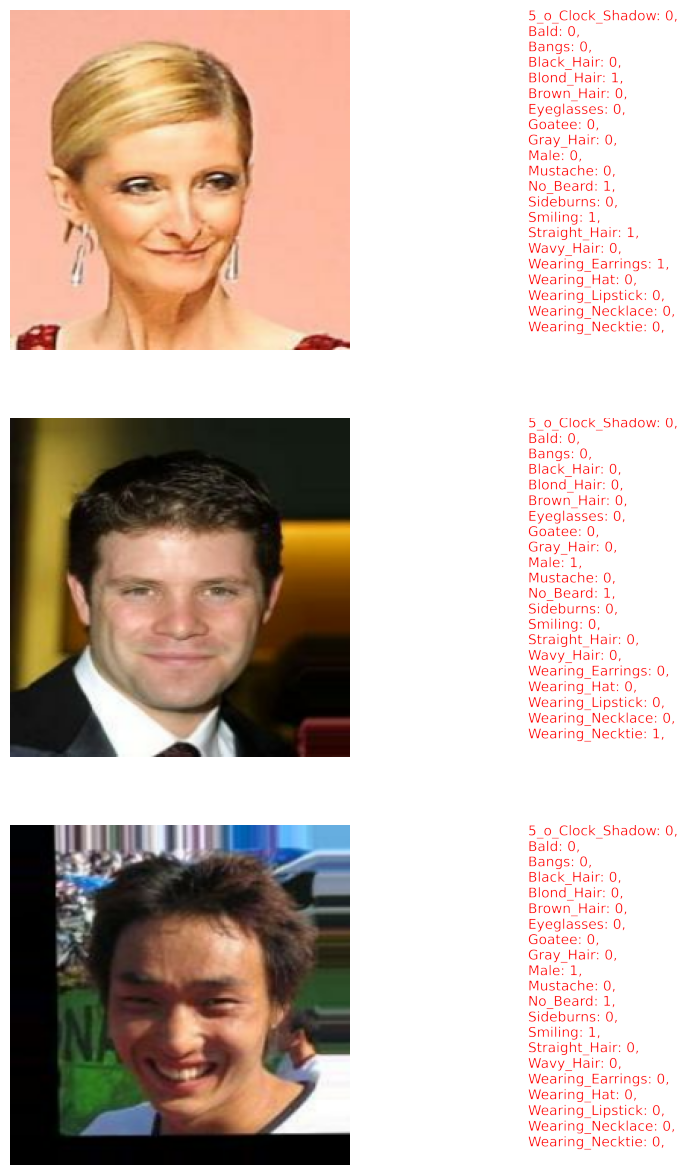

In [23]:
next_batch = next(iter(train_ds))
plt.tight_layout()
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    axs[i, 0].imshow(next_batch[0][i].numpy().astype("uint8"))
    axs[i, 0].axis("off")
    s = ""
    for j in range (len(selected_attributes)):
        s = s + f"{selected_attributes[j]}: {next_batch[j+1][i].numpy()},\n"
    rgba = text_to_rgba(s, color="red", fontsize=50, dpi=200)
    axs[i, 1].imshow(rgba)
    axs[i, 1].axis("off")

In [24]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

In [25]:
def apply_preprocessing_model(images, *args):
    return (preprocessing_model(images), (args))

In [26]:
def apply_normalization_layer(images, *args):
    return (normalization_layer(images), (args))

In [27]:
train_ds = train_ds.map(apply_preprocessing_model)
val_ds = val_ds.map(apply_normalization_layer)

In [28]:
list(train_ds.take(1).as_numpy_iterator())

2023-04-12 13:49:36.481851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_7}}]]
2023-04-12 13:49:36.483010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_12}}]]


[(array([[[[0.03137255, 0.03137255, 0.03137255],
           [0.03137255, 0.03137255, 0.03137255],
           [0.03137255, 0.03137255, 0.03137255],
           ...,
           [0.03529412, 0.0332808 , 0.02543766],
           [0.03529412, 0.03137255, 0.02111338],
           [0.03529412, 0.03137255, 0.01568628]],
  
          [[0.03137255, 0.03137255, 0.03137255],
           [0.03137255, 0.03137255, 0.03137255],
           [0.03137255, 0.03137255, 0.03137255],
           ...,
           [0.03529412, 0.0332808 , 0.02543766],
           [0.03529412, 0.03137255, 0.02111338],
           [0.03529412, 0.03137255, 0.01568628]],
  
          [[0.03137255, 0.03137255, 0.03137255],
           [0.03137255, 0.03137255, 0.03137255],
           [0.03137255, 0.03137255, 0.03137255],
           ...,
           [0.03529412, 0.0332808 , 0.02543766],
           [0.03529412, 0.03137255, 0.02111338],
           [0.03529412, 0.03137255, 0.01568628]],
  
          ...,
  
          [[0.03895312, 0.03110998, 0.03

In [29]:
do_fine_tuning = False
image_input = tf.keras.Input(shape=image_size + (3,))
en_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)(image_input)
en_model = tf.keras.layers.Dropout(rate=0.2)(en_model)
en_model = tf.keras.layers.Dense(128, activation="relu")(en_model)
output_layers = []
for attr in selected_attributes:
    output_layers.append(tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name=f'{attr}')(en_model))

model = tf.keras.Model( inputs = image_input, outputs = output_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         5919312     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 128)          163968      ['dropout[0][0]']            

In [30]:
model.compile(
    loss = {f"{attr}": tf.keras.losses.BinaryCrossentropy() for attr in selected_attributes},
    metrics = {f"{attr}": 'accuracy' for attr in selected_attributes},
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [31]:
steps_per_epoch = len(train_df) // batch_size
validation_steps = len(val_df) // batch_size
hist = model.fit(
    train_ds,
    epochs=3, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/3


2023-04-12 13:49:44.265034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_9}}]]
2023-04-12 13:49:44.266467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype int64 and shape [5000]
	 [[{{node Placeholder/_12}}]]
2023-04-12 13:49:46.045163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/head/StatefulPartitionedCall_grad/head/

39/39 [==============================] - ETA: 0s - loss: 7.1808 - 5_o_Clock_Shadow_loss: 0.3192 - Bald_loss: 0.1193 - Bangs_loss: 0.4059 - Black_Hair_loss: 0.4898 - Blond_Hair_loss: 0.3202 - Brown_Hair_loss: 0.5515 - Eyeglasses_loss: 0.1988 - Goatee_loss: 0.2211 - Gray_Hair_loss: 0.1833 - Male_loss: 0.2779 - Mustache_loss: 0.2095 - No_Beard_loss: 0.3506 - Sideburns_loss: 0.2185 - Smiling_loss: 0.6651 - Straight_Hair_loss: 0.5289 - Wavy_Hair_loss: 0.5326 - Wearing_Earrings_loss: 0.4587 - Wearing_Hat_loss: 0.1414 - Wearing_Lipstick_loss: 0.3714 - Wearing_Necklace_loss: 0.3885 - Wearing_Necktie_loss: 0.2243 - 5_o_Clock_Shadow_accuracy: 0.8744 - Bald_accuracy: 0.9706 - Bangs_accuracy: 0.8458 - Black_Hair_accuracy: 0.7588 - Blond_Hair_accuracy: 0.8650 - Brown_Hair_accuracy: 0.7885 - Eyeglasses_accuracy: 0.9395 - Goatee_accuracy: 0.9359 - Gray_Hair_accuracy: 0.9447 - Male_accuracy: 0.8854 - Mustache_accuracy: 0.9361 - No_Beard_accuracy: 0.8281 - Sideburns_accuracy: 0.9355 - Smiling_accuracy:

2023-04-12 13:51:44.732182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64 and shape [1000]
	 [[{{node Placeholder/_7}}]]
2023-04-12 13:51:44.733007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype int64 and shape [1000]
	 [[{{node Placeholder/_19}}]]


39/39 [==============================] - 142s 3s/step - loss: 7.1808 - 5_o_Clock_Shadow_loss: 0.3192 - Bald_loss: 0.1193 - Bangs_loss: 0.4059 - Black_Hair_loss: 0.4898 - Blond_Hair_loss: 0.3202 - Brown_Hair_loss: 0.5515 - Eyeglasses_loss: 0.1988 - Goatee_loss: 0.2211 - Gray_Hair_loss: 0.1833 - Male_loss: 0.2779 - Mustache_loss: 0.2095 - No_Beard_loss: 0.3506 - Sideburns_loss: 0.2185 - Smiling_loss: 0.6651 - Straight_Hair_loss: 0.5289 - Wavy_Hair_loss: 0.5326 - Wearing_Earrings_loss: 0.4587 - Wearing_Hat_loss: 0.1414 - Wearing_Lipstick_loss: 0.3714 - Wearing_Necklace_loss: 0.3885 - Wearing_Necktie_loss: 0.2243 - 5_o_Clock_Shadow_accuracy: 0.8744 - Bald_accuracy: 0.9706 - Bangs_accuracy: 0.8458 - Black_Hair_accuracy: 0.7588 - Blond_Hair_accuracy: 0.8650 - Brown_Hair_accuracy: 0.7885 - Eyeglasses_accuracy: 0.9395 - Goatee_accuracy: 0.9359 - Gray_Hair_accuracy: 0.9447 - Male_accuracy: 0.8854 - Mustache_accuracy: 0.9361 - No_Beard_accuracy: 0.8281 - Sideburns_accuracy: 0.9355 - Smiling_accu

In [1]:
a = 1

In [2]:
a

1